# remove invalid samples
# filter


In [1]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing
from tqdm import tqdm
from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from peakDetection.python.PeakDetector import PeakDetector  
from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
# os.listdir('/kaggle/input/BloodPressureDataset')

In [30]:
test = np.load("../data/raw/BloodPressureDataset/signal_windowed_train.npy")
print(test.shape)

(196742, 3, 1250)


In [2]:
test = np.load("../data/raw/BloodPressureDataset/signal_windowed_test.npy")
print(test.shape)

(64916, 3, 1250)


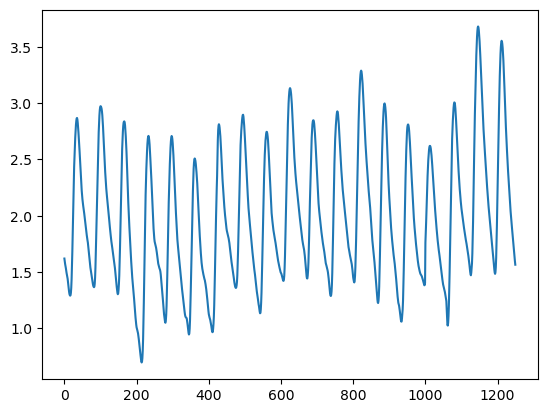

In [30]:
plt.plot(test[0,0,:])

In [86]:
detector = PeakDetector()
detector.clear()
# bp = np.zeros((test.shape[0],2))
mask = np.zeros((test.shape[0],3),dtype=bool) * True
for i in tqdm(range(test.shape[0])):
    detector.update(test[i,1,:])
    sbp = test[i,1,detector.max_i[np.argmax(detector.max_v)]]
    dbp = test[i,1,detector.min_i[np.argmin(detector.min_v)]]
    detector.clear()
    # print(sbp,dbp)
    # print((20 < (sbp-dbp) < 70))
    mask[i,0] = 20 < (sbp-dbp) < 70
    mask[i,1] = (50 < dbp < 110)
    mask[i,2] = (90 < sbp < 180)

print(np.unique(mask,return_counts=True))

100%|██████████| 196742/196742 [45:58<00:00, 71.33it/s]

(array([False,  True]), array([105463, 484763], dtype=int64))


In [20]:
# np.save("../data/raw/BloodPressureDataset/bp_mask_train.npy",mask)

In [27]:
mask = np.load("../data/raw/BloodPressureDataset/bp_mask_train.npy")
print(mask.shape)

(196742,)


In [31]:
# mask = np.all(mask,axis=1)
np.unique(mask,return_counts=True)
test= test[mask]
print(test.shape)
test = test[~np.isnan(test).any(axis=2).any(axis=1)]
print(test.shape)


(98476, 3, 1250)


In [32]:

print(test.shape)

(98475, 3, 1250)


In [10]:
print(test[43994,2])

[0.125      0.18505859 0.24511719 ... 0.54003906 0.51513672 0.47998047]


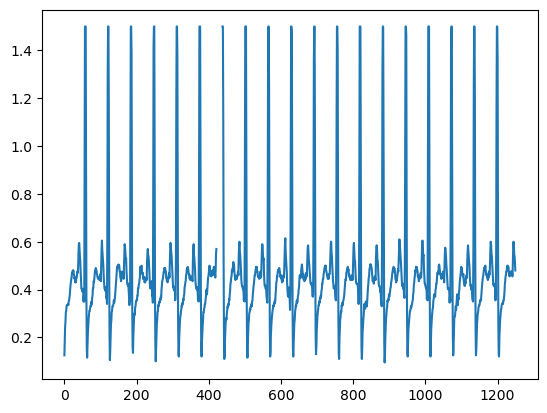

In [11]:
plt.plot(test[43994,2])

In [19]:
test.shape

AttributeError: 'list' object has no attribute 'shape'

In [33]:
np.save("../data/raw/BloodPressureDataset/signal_train_bp_masked1.npy",test[:50000])
np.save("../data/raw/BloodPressureDataset/signal_train_bp_masked2.npy",test[50000:])

In [6]:
print(np.unique(mask[:,0],return_counts=True))
print(np.unique(mask[:,1],return_counts=True))
print(np.unique(mask[:,2],return_counts=True))
print(np.where(~mask[:,0])[0][:5])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

sbp: 149.95140011624898 dbp: 57.538354832879904 diff: 92.41304528336907


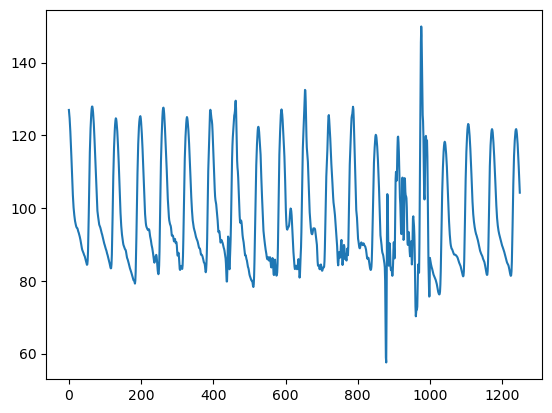

In [82]:
i = 0
detector.update(test[i,1])
plt.plot(test[i,1])
plt.plot(detector.max_i, detector.max_v,'+r',mew=2, ms=10)
plt.plot(detector.min_i, detector.min_v,'+g',mew=2, ms=10)
sbp = test[i,1,detector.max_i[np.argmax(detector.max_v)]]
dbp = test[i,1,detector.min_i[np.argmin(detector.min_v)]]
detector.clear()
print("sbp:",sbp,"dbp:",dbp,"diff:",sbp-dbp)

# filter

In [35]:

def bandpass_butter(signal,low,high):
    fs = 125
    numtaps =255
    filter = signal.butter(numtaps=numtaps, cutoff=[low,high], fs=fs, pass_zero=True)
    return signal.filtfilt(filter, 1, signal)

def lowpass_fir(signal,low):
    fs = 125
    numtaps =255
    filter = signal.firwin(numtaps=numtaps, cutoff=low, fs=fs, pass_zero=True)
    return signal.filtfilt(filter, 1, signal)

def savgol(signal,window,polyorder):
    return signal.savgol_filter(signal,window_length=window,polyorder=polyorder)

def chebyshev2(signal,order,rs):
    filter  =signal.cheby2(N=order,rs=rs,btype='bandpass',output='sos')
    return signal.sosfiltfilt(filter,signal)


In [ ]:
ecg = test[:,2,:]
band_40 = bandpass_butter(ecg,0.01,40)
band_20 = bandpass_butter(ecg,0.01,20)
low_03 =bandpass_butter(ecg,0.01,0.3)
low_05 = bandpass_butter(ecg,0.01,0.5)
nyq_09 = lowpass_fir(ecg,0.9)
savgol_33 = savgol(ecg,3,3) 
savgol_31 = savgol(ecg,3,1)
chebyshev_62= chebyshev2(ecg,6,10)

In [ ]:
train = np.load("../data/raw/BloodPressureDataset/signal_windowed_train.npy")